In [1]:
import tensorflow as tf
import torch
import random
import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.keras.backend as K
from sklearn.preprocessing import OneHotEncoder
tf.config.run_functions_eagerly(True)


In [2]:
#change current directory up to parent, only run 1 time!
os.chdir("..")

In [42]:
#encoder
def downsample(filters, size, apply_batchnorm=True,stride=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

# load data

In [41]:
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1498):
    train_data_input=[]
    train_data_target=[]
    
    for n in range(nr_img):
        n1=n
        if test:
            n1=f'{n}_a'
        try:
            test1=np.load(f'{path}/{n1}.npy')
            inputs=test1[:3].transpose()
            inputs=tf.convert_to_tensor(inputs)
            inputs=inputs[tf.newaxis,...]
            target=test1[3].transpose()
            target=tf.convert_to_tensor(target)
            target=target[...,tf.newaxis]
            target=target[tf.newaxis,...]

            
            train_data_input.append(inputs)
            train_data_target.append(target)
        except:
            if Print:
                print(f'fil nr {n} mangeler')
    return [train_data_input,train_data_target]

In [5]:
test_data=load_data(test=True)
train_data=load_data()

In [6]:
def Get_stats(data):
    print(f'Number of training img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')

print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)


#  one hot encoder


In [7]:
depth = 8

In [8]:
test_data2=tf.one_hot(test_data[1], depth)[:,:,:,:,0,:]
train_data2=tf.one_hot(train_data[1], depth)[:,:,:,:,0,:]

In [9]:
test_data[1]=test_data2
train_data[1]=train_data2

In [10]:
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)


In [11]:
example_input, example_target=test_data[0][0],test_data[1][0]

In [12]:
down_model = downsample(3, 4)

In [47]:
#decoder
def upsample(filters, size, apply_dropout=False,stride=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
up_model = upsample(3, 4)
print(up_model)

In [136]:
def Generator1():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(8, (3,3), apply_batchnorm=False,stride=1),  # (batch_size, 256, 128, 64)
    downsample(8, (3,3),stride=1),
    downsample(8, (3,3)),# (batch_size, 128, 64, 128)
    downsample(16, (3,3),stride=1),  # (batch_size, 128, 32, 256)
    downsample(16, (3,3),stride=1),  # (batch_size, 128/2, 16, 512)
    downsample(16, (3,3)),  # (batch_size, 8, 64, 512)
    downsample(32, (3,3),stride=1),  # (batch_size, 64, 32, 256)
    downsample(32, (3,3),stride=1),  # (batch_size, 64, 16, 512)
    downsample(32, (3,3)),  # (batch_size, 32, 8, 512)
      
    downsample(64, (3,3),stride=1),
    downsample(64, (3,3),stride=1),
    downsample(64, (3,3)),
      
    downsample(128, (3,3),stride=1),  # (batch_size, 16, 16, 256)
    downsample(128, (3,3),stride=1),  # (batch_size, 16, 16, 512)
    downsample(8, (3,3),stride=1),  # (batch_size, 16, 16, 512)
      
  ]

  up_stack = [
    upsample(32, (2,2),stride=2),  # (batch_size, 16, 16, 32)
    downsample(32, (3,3),stride=1),  # (batch_size, 16, 16, 1024)
    downsample(32, (3,3),stride=1),  # (batch_size, 16, 16, 1024)

    
    upsample(32, (2,2),stride=2),  # (batch_size, 8, 8, 1024)
    downsample(32, (3,3),stride=1),  # (batch_size, 16, 16, 1024)
    downsample(32, (3,3),stride=1),  # (batch_size, 32, 32, 512)
      
    upsample(16, (2,2),stride=2),  # (batch_size, 8, 8, 1024)
    downsample(16, (3,3),stride=1),  # (batch_size, 16, 16, 1024)
    downsample(16, (3,3),stride=1),  # (batch_size, 32, 32, 512)
    
    upsample(8, (2,2),stride=2),  # (batch_size, 8, 8, 1024)
    downsample(8, (3,3),stride=1),  # (batch_size, 16, 16, 1024)
    downsample(8, (3,3),stride=1),  # (batch_size, 32, 32, 512)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=8
  softlayer=tf.keras.layers.Softmax(axis = -1)


  x = inputs
    
  x=tf.keras.layers.Dropout(0.5)(x)


  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])
  print(skips)
  x=tf.keras.layers.Flatten()(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.Dense(256)(x)
  x=tf.keras.layers.Dropout(0.5)(x)
  x=tf.keras.layers.Dense(512)(x)
  x=tf.keras.layers.Reshape((16,16,2))(x)
  
  
  # Upsampling and establishing the skip connections
  n=0
  conc=[1,4,7,10,13]
  for up, skip in zip(up_stack, skips):
    n+=1
    if n in conc:
        print("hey")
        x = tf.keras.layers.Concatenate()([x, skip])
    x = up(x)
  x = softlayer(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

In [67]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Dropout, Flatten, Reshape, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

def generator2():
    # Build U-Net model
    out_depth=8
    fcl_size=256
    inputs = Input(shape=[256, 256, 3])
    s = BatchNormalization()(inputs) # we can learn the normalization step
    s = Dropout(0.5)(s)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    c5_min = Conv2D(out_depth, (3, 3), activation='relu', padding='same') (c5)

    # fully connected component for spatial sensitivity
    flat_c5 = Dropout(0.5)(Flatten()(c5_min))
    fcl_c5 = Dropout(0.5)(Dense(fcl_size)(flat_c5))
    out_shape = c5._keras_shape[1:3]+(out_depth,)
    fcl_c5_imgflat = Dense(np.prod(out_shape))(fcl_c5)
    fcl_img = Reshape(out_shape)(fcl_c5_imgflat)
    new_c5 = concatenate([c5, fcl_img])

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (new_c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

In [75]:
generator2()

AttributeError: 'KerasTensor' object has no attribute '_keras_shape'

hey
hey
hey
hey


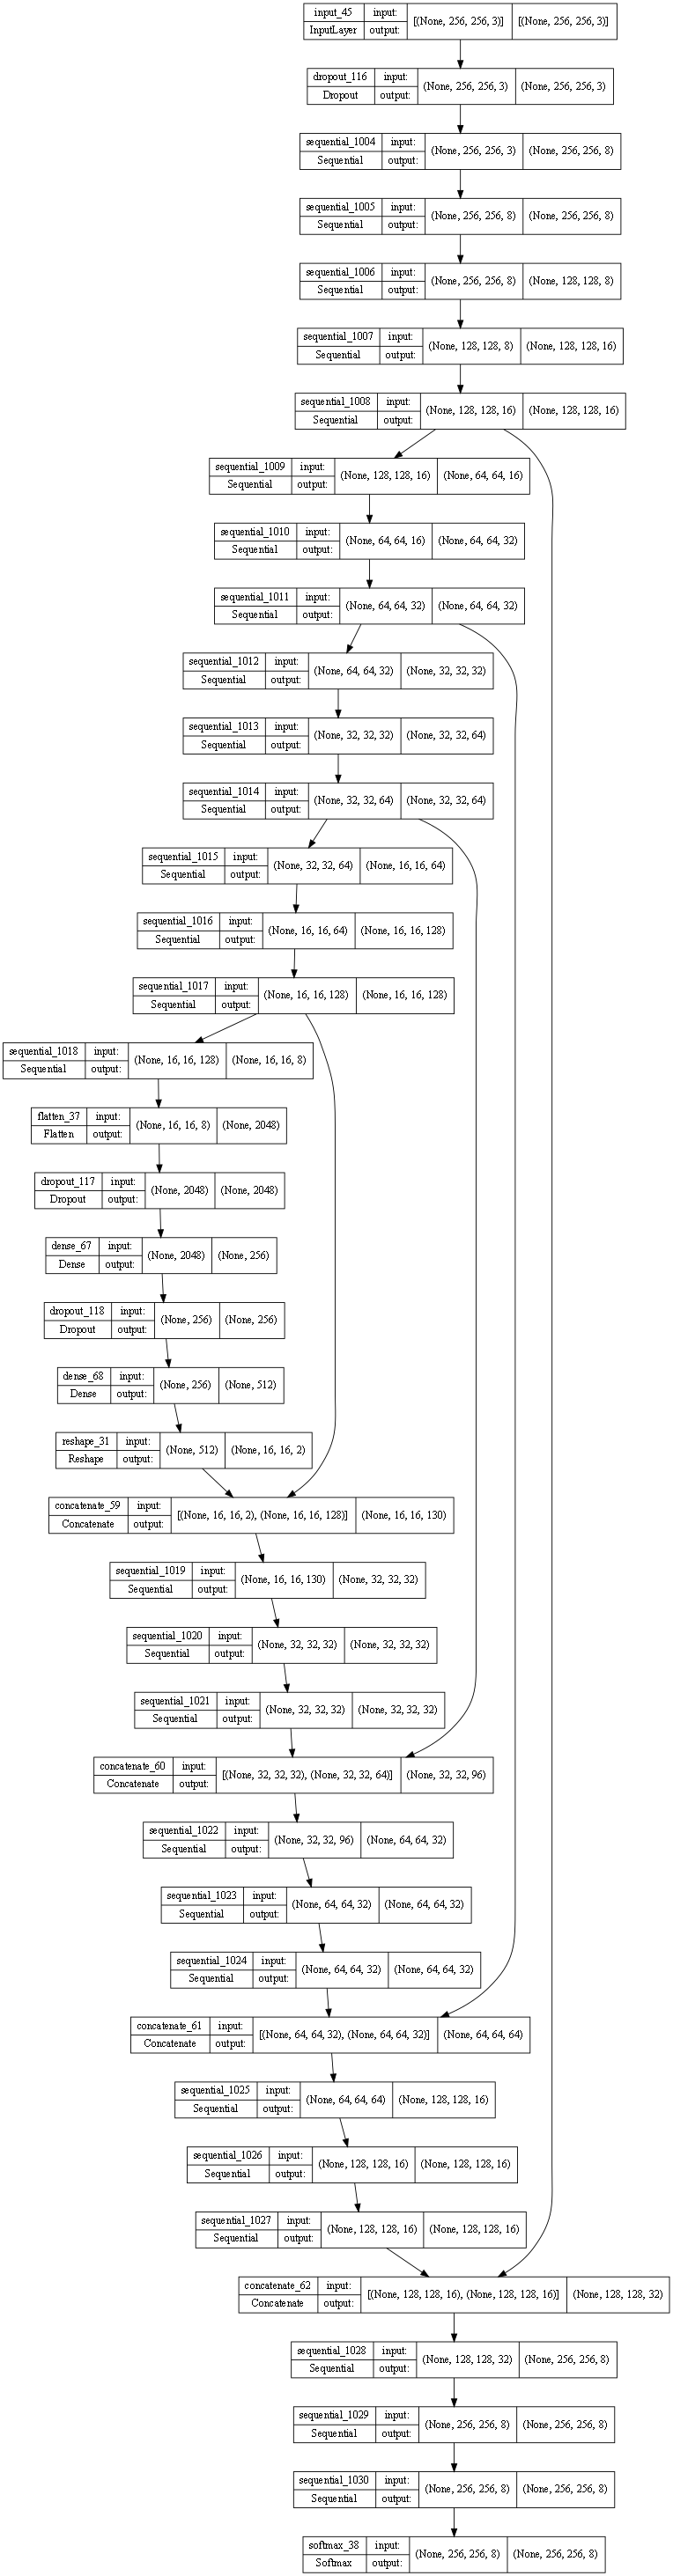

In [137]:
generator1 = Generator1()
tf.keras.utils.plot_model(generator1, show_shapes=True, dpi=64)

In [97]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 2, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),
    downsample(128, 2),# (batch_size, 64, 64, 128)
    downsample(256, 2),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 2),  # (batch_size, 4, 4, 512)
    #downsample(512, 7),  # (batch_size, 2, 2, 512)
    #downsample(512, 7),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 7, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample(512, 7, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 2),  # (batch_size, 16, 16, 1024)
    upsample(256, 2),  # (batch_size, 32, 32, 512)
    upsample(128, 3),
    upsample(128, 2), # (batch_size, 64, 64, 256)
    upsample(64, 2),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=8
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  softlayer=tf.keras.layers.Softmax(axis = -1)


  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  
  x = softlayer(x)
  #x = tf.math.argmax(x, axis = -1)[...,tf.newaxis]
  return tf.keras.Model(inputs=inputs, outputs=x)

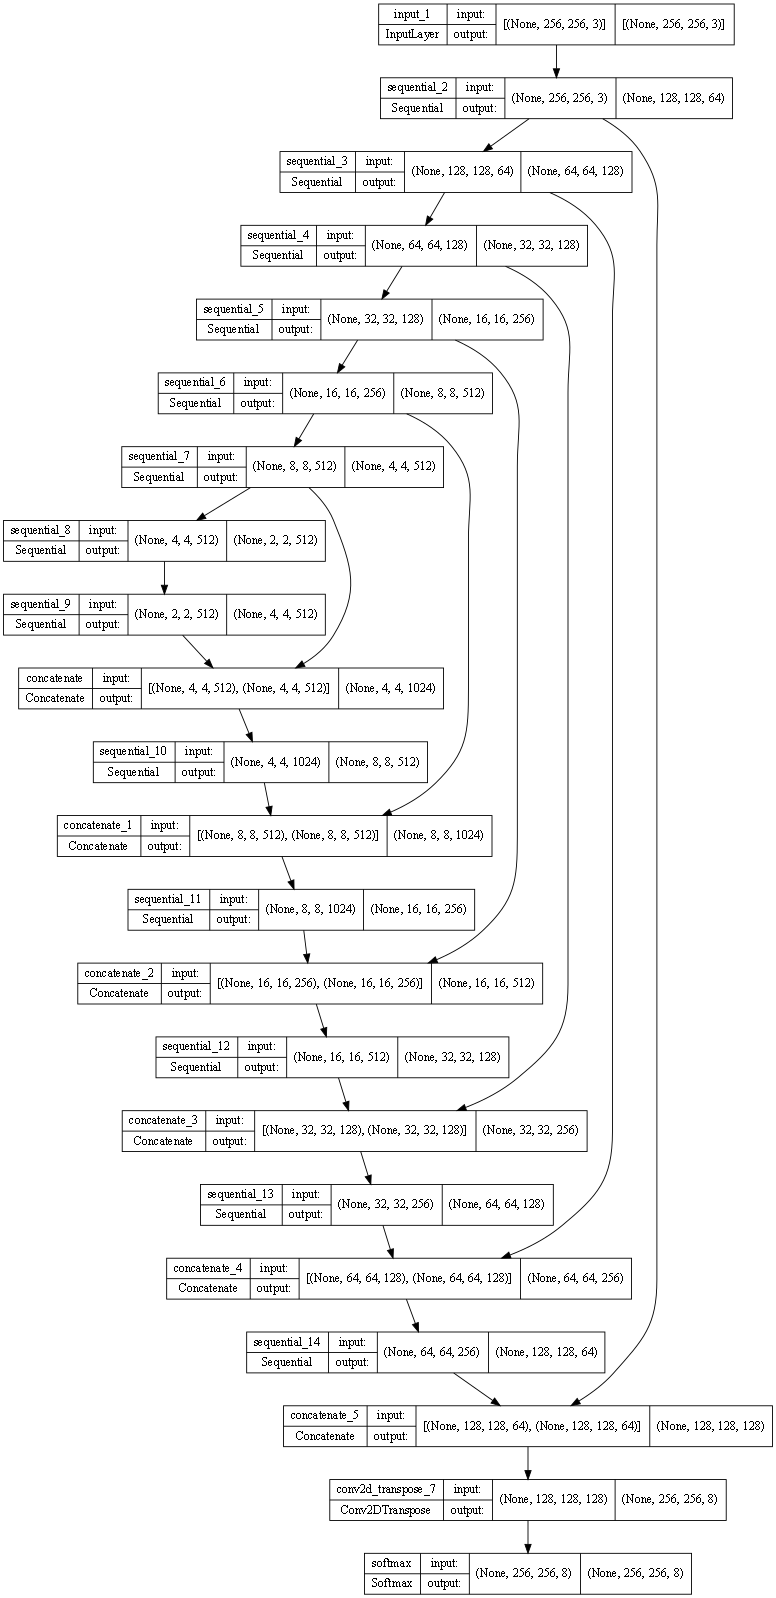

In [16]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [17]:
#print(test_data[0][0].shape)
gen_output = generator(test_data[0][0], training=False)
#print(gen_output.shape)
#gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]
#print(gen_output.shape)
#plt.imshow(gen_output[0, ...])
#print(gen_output)

# loos

In [18]:
LAMBDA = 1

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def dice_coef(y_true, y_pred, smooth=0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


In [21]:
def generator_loss(disc_generated_output, gen_output, target,gansco=0 ):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss=1-dice_coef(target,gen_output)

  total_gen_loss = gan_loss*gansco + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [22]:
def generator_loss1(disc_generated_output, gen_output,  target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  y_true_f = K.flatten(target)
  y_pred_f = K.flatten(gen_output)
    
  l111=(y_true_f) - (y_pred_f)
  l11=tf.abs(l111)
  l1_loss = tf.reduce_mean(l11)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [23]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  
  tar = tf.keras.layers.Input(shape=[256, 256, 8], name='target_image')
  
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
 
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

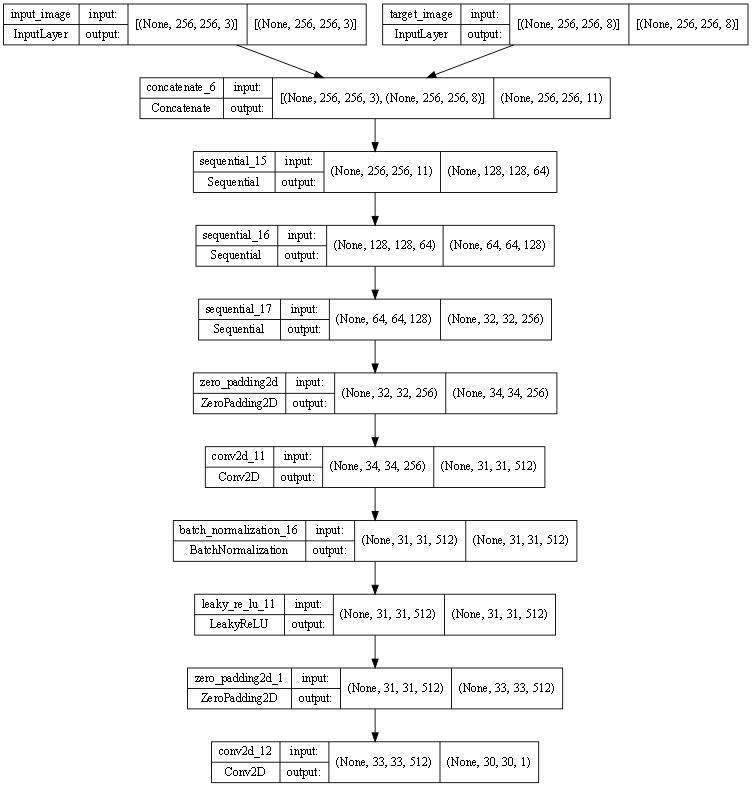

In [24]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):


  total_disc_loss = -dice_coef(disc_real_output,disc_generated_output)

  return total_disc_loss

In [26]:
def discriminator_loss1(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

In [28]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  #print(prediction[0])
  display_list = [test_input[0], tf.argmax(tar[0],axis=-1),tf.argmax(prediction[0],axis=-1) ]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]) #* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [29]:
def generate_loses(loses):

    plt.show
    title = ['gen_total_loss', 'gen_gan_loss', 'gen_l1_loss','disc_loss']

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.title(title[i])
        plt.plot(loses[1:,i])
    plt.show()

In [30]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [31]:
@tf.function
def train_step(input_image, target, step,unet=True):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    #gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  #discriminator_gradients = disc_tape.gradient(disc_loss,
                                               #discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  #discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              #discriminator.trainable_variables))
  losees=np.array([gen_total_loss.numpy(),gen_gan_loss.numpy(),gen_l1_loss.numpy(),disc_loss.numpy()])
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
  return losees

In [34]:
def fit(train_ds, test_ds, steps,batch_size=4):
  randomnr=random.randint(0,len(test_ds[0])-1)
  example_input, example_target=test_ds[0][randomnr],test_data[1][randomnr]
  start = time.time()
  losees=np.array([[0,0,0,0]])
  for step in range(steps):
    r1=random.randint(0,len(train_ds[0])-1)
    input_image=train_ds[0][r1]
    target=train_ds[1][r1]
    for n in range(batch_size-1):  
        r2=random.randint(0,len(train_ds[0])-1)
        input_image2=train_ds[0][r1]
        target2=train_ds[1][r1]
        input_image=tf.concat([input_image2,input_image],0)
        target=tf.concat([target2,target],0)
    
    if(step) % 10 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')
        #print(losees)

      start = time.time()

      generate_images(generator, example_input, example_target)
      generate_loses(losees)
      print(f"Step: {step//1000}0")
    l=train_step(input_image, target, step)
    losees=np.append(losees,np.array([l]),axis=0)  
      
  
    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    #if (step + 1) % 5000 == 0:
      #checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
[1,2,3]*[2,2,2]

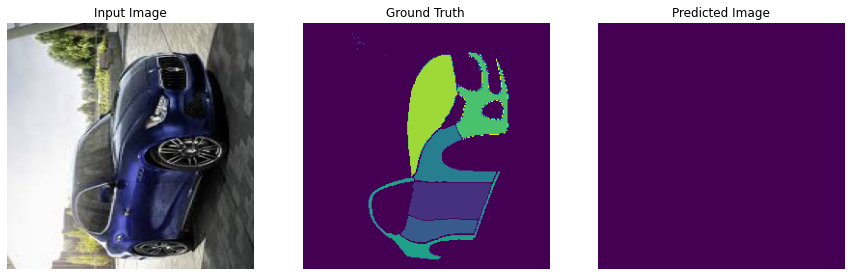

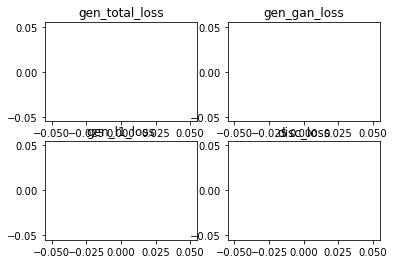

Step: 00


KeyboardInterrupt: 

In [36]:
fit(train_data, test_data, steps=1000)

In [ ]:
c = tf.constant([1.0, 0.0,0.0])
d = tf.constant([0.9, 0.3,0.3])
1-K.sum(c*d)